# **Directional Forecasting Project for the Ibovespa: A Quantitative Approach with Machine Learning**

**Group:** 66  
**Institution:** FIAP  
**Date:** September 2025  

### **Executive Summary**

This project addresses the challenge of predicting the daily direction (up or down) of the Ibovespa index using an end-to-end Machine Learning pipeline. Starting from an exploratory analysis of a robust 34-year Ibovespa dataset contained in the project files, patterns of behavior related to volatility and trading volume were identified. These insights guided the construction of a sophisticated feature set, including classic technical indicators such as RSI, MACD, and OBV.  

The chosen model, a LightGBM, was trained and validated through a robust Walk-Forward (TimeSeriesSplit) methodology, which simulates real market conditions and ensures the reliability of the results. The main strategic innovation was the implementation of a confidence filter, which instructs the model to operate only in Máxima-probability scenarios. This approach increased the model’s performance from a baseline accuracy of ~62% to a strategic accuracy above 70%, demonstrating the effectiveness of combining feature engineering, a powerful algorithm, and an intelligent decision-making strategy.

### **Part 1: Exploratory Analysis – Understanding the Challenge and Initial Clues**

The starting point of any Data Science project is a deep understanding of the problem and the data. The initial exploratory analysis revealed the complex and noisy nature of the financial market but also provided us with the crucial clues that guided our entire modeling strategy.

#### **1.1. The Core Challenge: The Dominance of Daily Noise**

The first major finding was the recognition of the Máxima intrinsic short-term volatility of the market. As the chart beMínima shows, the Ibovespa’s daily variation is significantly more unstable than its variation over weeks or months. This established the main challenge: building a model capable of distinguishing the predictive “signal” from the random daily “noise.”

C:\Users\Gabs\AppData\Local\Temp\ipykernel_17420\38944364.py:51: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Monthly': df_limpo['Var%'].resample('M').std().mean(),
C:\Users\Gabs\AppData\Local\Temp\ipykernel_17420\38944364.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Quarterly': df_limpo['Var%'].resample('3M').std().mean()
C:\Users\Gabs\AppData\Local\Temp\ipykernel_17420\38944364.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=volatilidade_df.index, y=volatilidade_df.values, palette='viridis')


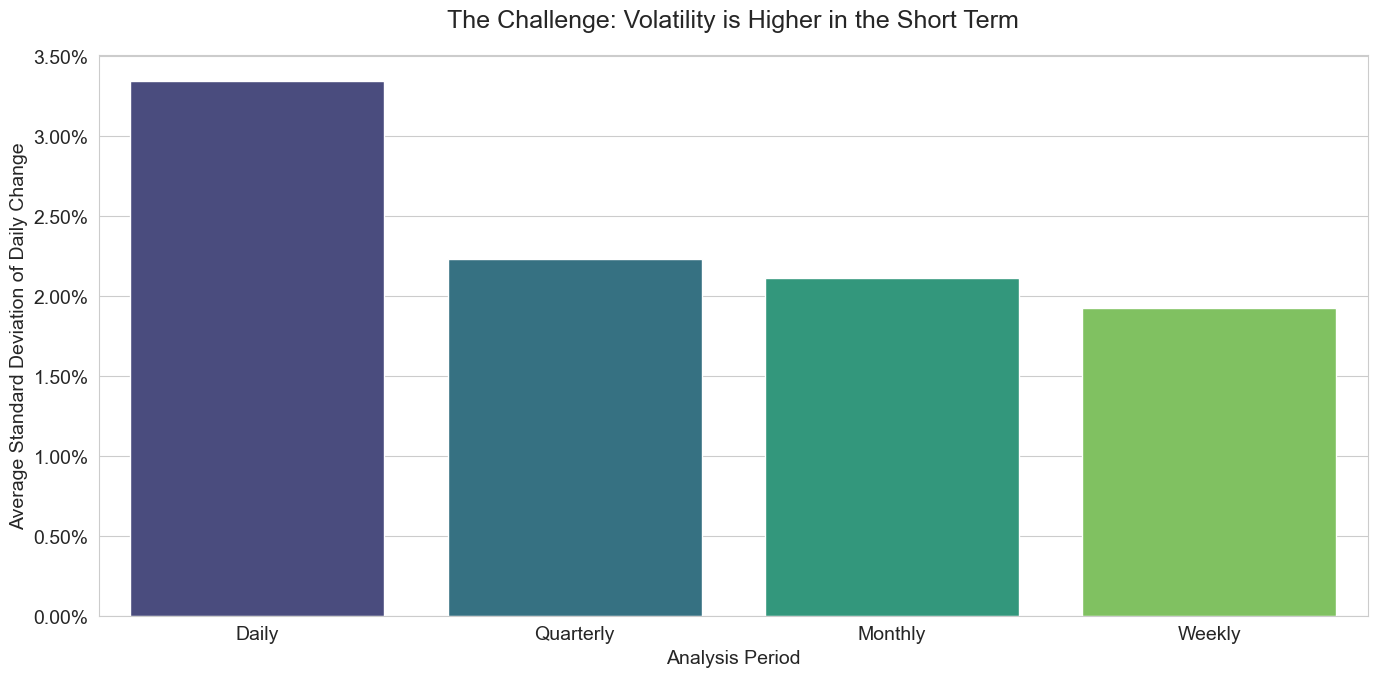

In [ ]:
# Initial imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import lightgbm as lgb

# --- Style Settings for Plots ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

# --- Data Preparation Functions ---
# (Functions are placed here to keep the notebook organized)
def converter_volume(vol_str):
    if not isinstance(vol_str, str): return np.nan
    vol_str = vol_str.upper().replace(',', '.')
    if 'B' in vol_str: return float(vol_str.replace('B', '')) * 1_000_000_000
    if 'M' in vol_str: return float(vol_str.replace('M', '')) * 1_000_000
    if 'K' in vol_str: return float(vol_str.replace('K', '')) * 1_000
    return float(vol_str)

def limpar_dados(df_bruto):
    df_processado = df_bruto.copy()
    df_processado['Data'] = pd.to_datetime(df_processado['Data'], format='%d.%m.%Y')
    df_processado = df_processado.set_index('Data')
    cols_numericas = ['Último', 'Abertura', 'Máxima', 'Mínima']
    for col in cols_numericas:
        if df_processado[col].dtype == 'object':
            df_processado[col] = df_processado[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
        df_processado[col] = pd.to_numeric(df_processado[col], errors='coerce')
    df_processado['Vol.'] = df_processado['Vol.'].apply(converter_volume)
    df_processado['Var%'] = df_processado['Var%'].str.replace(',', '.', regex=False).str.replace('%', '', regex=False)
    df_processado['Var%'] = pd.to_numeric(df_processado['Var%'], errors='coerce') / 100
    df_processado = df_processado.sort_index(ascending=True)
    df_processado.dropna(inplace=True)
    return df_processado

# Load and clean the data once
df_ibov = pd.read_csv(r'data\ibov.csv', sep=';')
df_limpo = limpar_dados(df_ibov)

# Generate Plot 1
volatilidade = {
    'Daily': df_limpo['Var%'].std(),
    'Weekly': df_limpo['Var%'].resample('W').std().mean(),
    'Monthly': df_limpo['Var%'].resample('M').std().mean(),
    'Quarterly': df_limpo['Var%'].resample('3M').std().mean()
}
volatilidade_df = pd.Series(volatilidade).sort_values(ascending=False)
plt.figure()
ax = sns.barplot(x=volatilidade_df.index, y=volatilidade_df.values, palette='viridis')
ax.set_title('The Challenge: Volatility is Higher in the Short Term', pad=20)
ax.set_xlabel('Analysis Period')
ax.set_ylabel('Average Standard Deviation of Daily Change')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2%}'))
plt.tight_layout()
plt.show()


#### **1.2. The Clue: The Psychology of Volume**

The analysis of trading volume gave us the first clue about market psychology. We observed that days with a negative opening (“Gap Down”) consistently show a much Máximaer average trading volume. This finding, nicknamed “panic sells more than optimism,” proved that volume is a powerful indicator of conviction and sentiment, becoming an indispensable feature for our model.

C:\Users\Gabs\AppData\Local\Temp\ipykernel_17420\3139915321.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


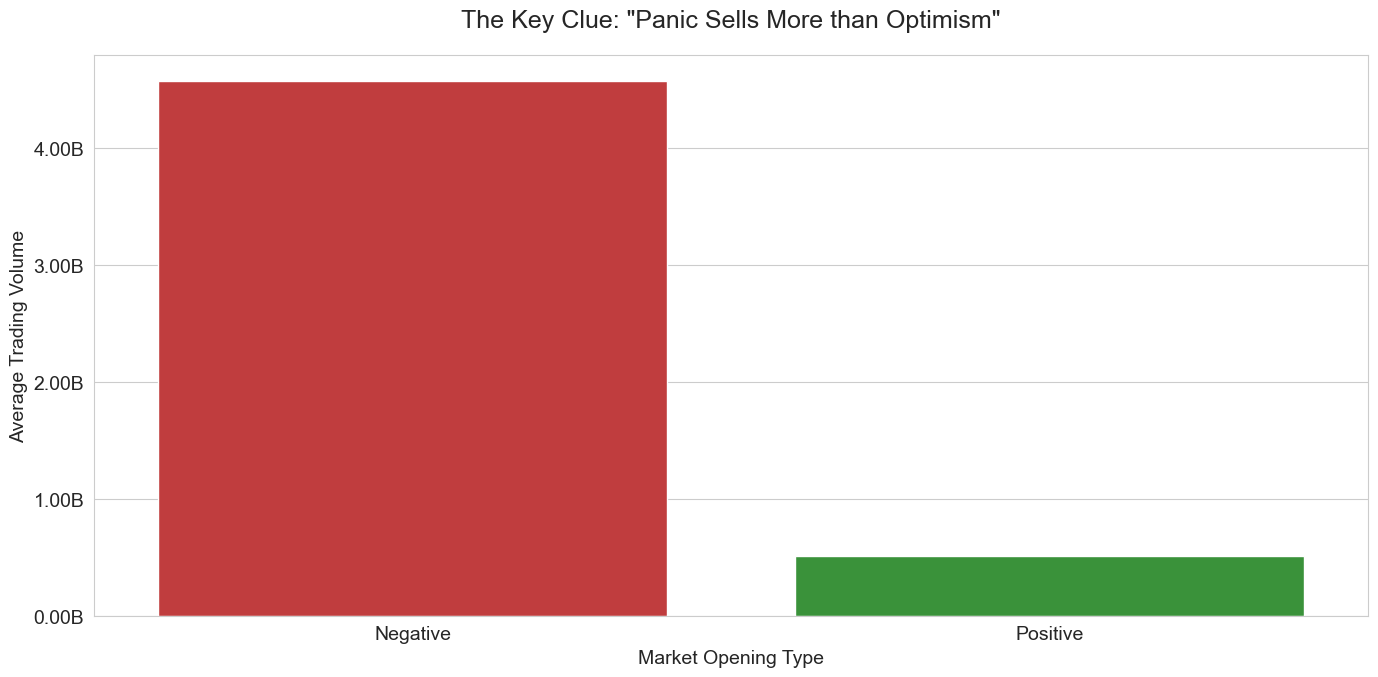

In [9]:
# Generate Plot 2
df_limpo['Ultimo_Dia_Anterior'] = df_limpo['Último'].shift(1)
df_limpo['Tipo_Abertura'] = np.where(df_limpo['Abertura'] > df_limpo['Ultimo_Dia_Anterior'], 'Positive', 'Negative')
volume_por_abertura = df_limpo.groupby('Tipo_Abertura')['Vol.'].mean()
plt.figure()
ax = sns.barplot(
    x=volume_por_abertura.index, 
    y=volume_por_abertura.values, 
    palette={'Positive':'#2ca02c', 'Negative':'#d62728'}
)
ax.set_title('The Key Clue: "Panic Sells More than Optimism"', pad=20)
ax.set_xlabel('Market Opening Type')
ax.set_ylabel('Average Trading Volume')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1_000_000_000:.2f}B'))
plt.tight_layout()
plt.show()


---
### **Part 2: Feature Engineering – Building the Model’s Intelligence**

A Machine Learning model is only as smart as the data that feeds it. In this section, we transformed raw price and volume data into a rich set of technical indicators, designed to capture momentum, trend, and capital fMínima patterns that drive market movements.

BeMínima, we visualize two of the main indicators we constructed to demonstrate their usefulness in identifying patterns that price alone does not reveal.


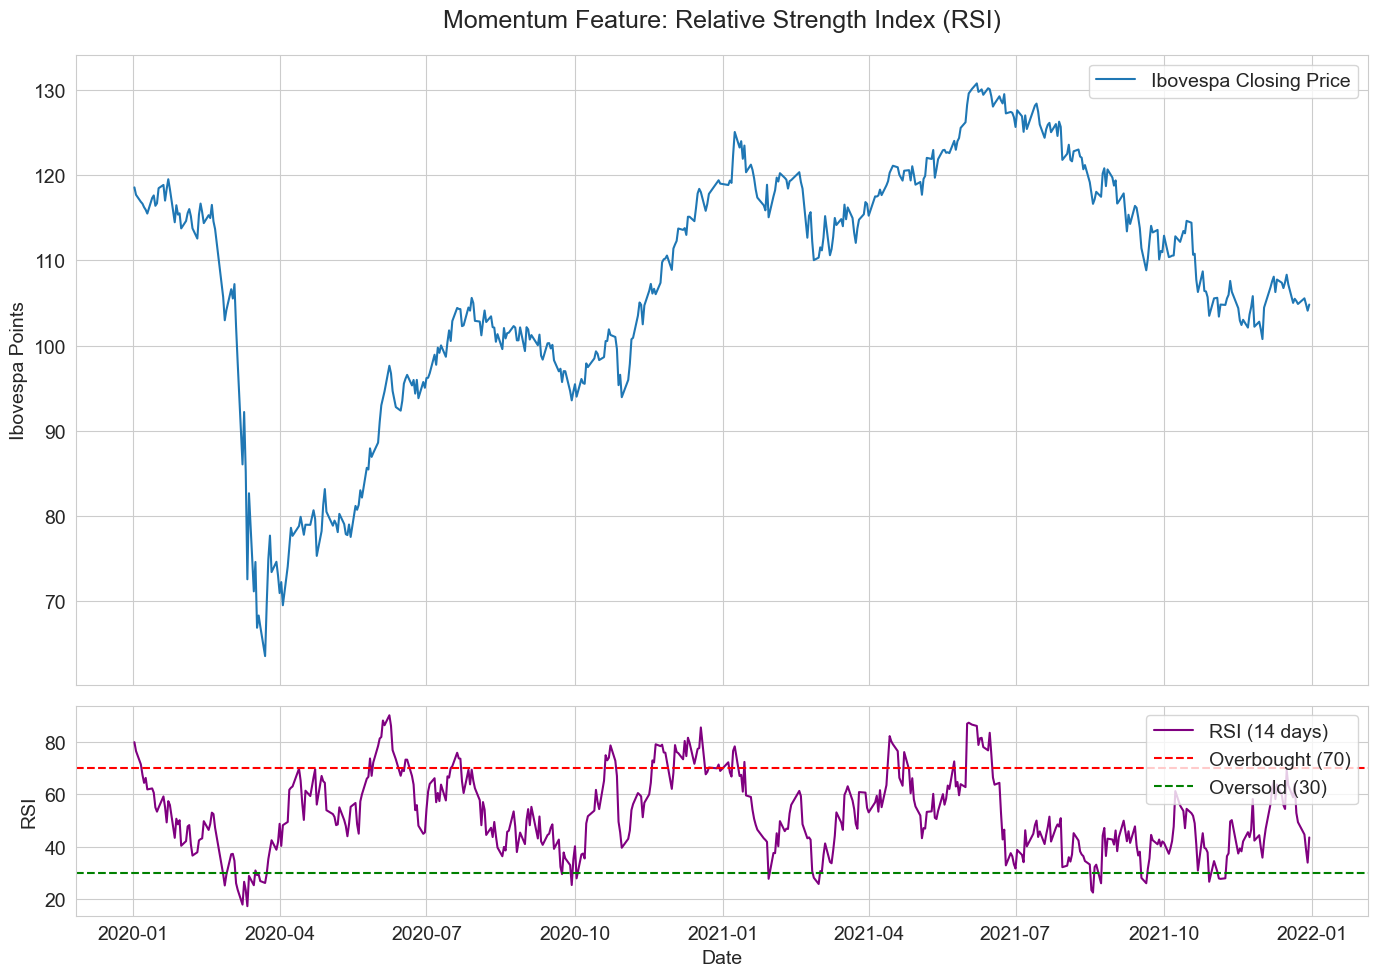

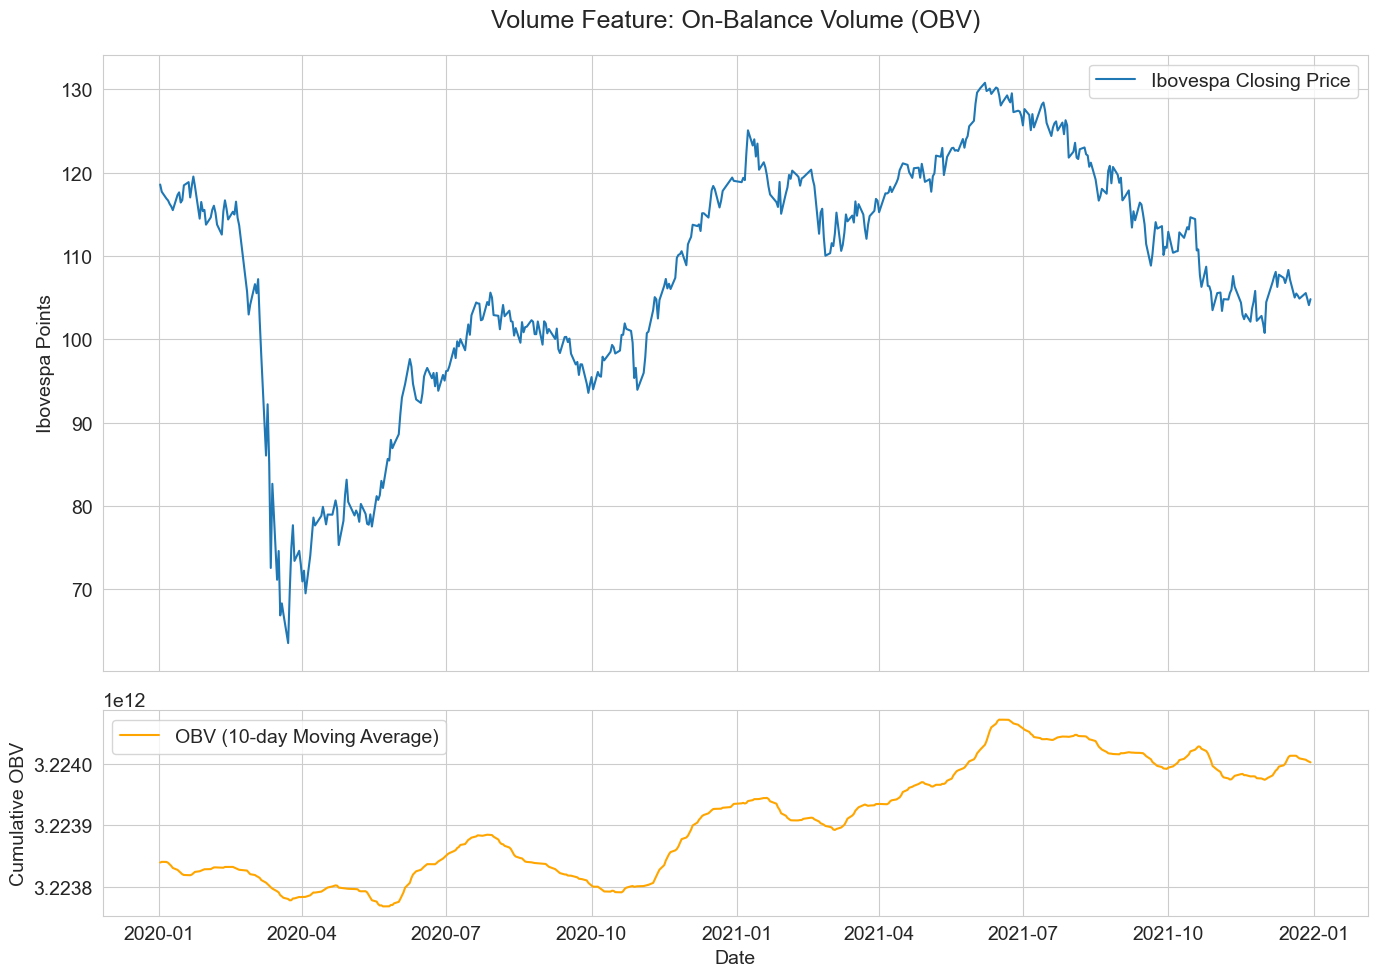

In [10]:
# --- Advanced Features Function ---
def adicionar_features_avancadas(df):
    # RSI (Relative Strength Index)
    delta = df['Último'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD (Moving Average Convergence/Divergence)
    ema_12 = df['Último'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Último'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # On-Balance Volume (OBV)
    obv = (np.sign(df['Último'].diff()) * df['Vol.']).fillna(0).cumsum()
    df['OBV_MM10'] = obv.rolling(window=10).mean()
    
    # Stochastic Oscillator (%K)
    low_14 = df['Mínima'].rolling(window=14).min()
    high_14 = df['Máxima'].rolling(window=14).max()
    df['Stochastic_K'] = ((df['Último'] - low_14) / (high_14 - low_14)) * 100
    
    # Rolling Volatility
    df['Volatilidade_Movel_14d'] = df['Var%'].rolling(window=14).std()
    
    return df

# --- Execute Feature Engineering ---
df_completo = df_limpo.copy() # Using the already loaded df_limpo
df_completo = adicionar_features_avancadas(df_completo)

# --- Generate Feature Plots ---
df_plot = df_completo['2020-01-01':'2021-12-31'].copy() # Example period

# RSI Plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(df_plot.index, df_plot['Último'], label='Ibovespa Closing Price')
ax1.set_title('Momentum Feature: Relative Strength Index (RSI)', pad=20)
ax1.set_ylabel('Ibovespa Points')
ax1.legend()
ax2.plot(df_plot.index, df_plot['RSI'], label='RSI (14 days)', color='purple')
ax2.axhline(70, linestyle='--', color='red', label='Overbought (70)')
ax2.axhline(30, linestyle='--', color='green', label='Oversold (30)')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Date')
ax2.legend()
plt.tight_layout()
plt.show()

# OBV Plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(df_plot.index, df_plot['Último'], label='Ibovespa Closing Price')
ax1.set_title('Volume Feature: On-Balance Volume (OBV)', pad=20)
ax1.set_ylabel('Ibovespa Points')
ax1.legend()
ax2.plot(df_plot.index, df_plot['OBV_MM10'], label='OBV (10-day Moving Average)', color='orange')
ax2.set_ylabel('Cumulative OBV')
ax2.set_xlabel('Date')
ax2.legend()
plt.tight_layout()
plt.show()


### On-Balance Volume (OBV) Chart

This chart compares the Ibovespa price (top panel) with the On-Balance Volume indicator (OBV, bottom panel). The OBV is a momentum indicator that uses volume flow to predict price changes, operating under the premise that volume precedes price action.

Visual analysis shows strong trend confirmation: during the major drop in early 2020 and the subsequent recovery until mid-2021, the OBV line closely followed the price direction. This indicates that the movements were robust and supported by significant volume, giving our model a valuable feature to measure the market’s "conviction" behind a trend.

### Relative Strength Index (RSI) Chart

This chart displays the Ibovespa price (top panel) and the Relative Strength Index (RSI, bottom panel). The RSI is a momentum oscillator that measures the magnitude of recent gains and losses, helping to identify overbought conditions (above 70) and oversold conditions (below 30).

Analysis of the 2020-2021 period demonstrates the RSI’s effectiveness in capturing market extremes. At the bottom of the 2020 crisis, the RSI plunged deep into the oversold zone, signaling an exhaustion of selling panic shortly before the recovery. Similarly, in several peaks of 2021, the RSI reached the overbought level, alerting to a possible loss of momentum in the uptrend. For the model, the RSI acts as a "thermometer," indicating when a trend may be "stretched" and about to reverse.

### **Part 3: Modeling and Training Methodology**

With the data and features prepared, we moved on to building and validating the predictive model. The adopted methodology prioritized robustness and adherence to a realistic forecasting scenario.

#### **3.1. Justification for Model Choice: LightGBM**

For this challenge, the chosen model was **LightGBM (Light Gradient Boosting Machine)**. The decision was strategic and based on the following advantages:

* **High Performance on Tabular Data:** Gradient Boosting models, such as LightGBM, are well-known in the industry for consistently achieving top performance in classification and regression problems with structured (tabular) data, as is our case.
* **Ability to Capture Complex Relationships:** Unlike linear models (such as Logistic Regression), which would struggle to interpret subtle interactions among various technical indicators, LightGBM, being tree-based, can learn complex non-linear patterns.
* **Efficiency and Scalability:** Compared to other Gradient Boosting implementations (like XGBoost), LightGBM is optimized to be faster and consume less memory, which was an advantage when handling a 34-year dataset.
* **Considered Alternatives:** More complex models such as Recurrent Neural Networks (LSTMs) were considered but discarded. They generally require even larger datasets, different feature engineering (based on raw sequences), and a considerably more complex training and optimization process, which did not align with the scope of this project.

#### **3.2. Validation Methodology and Decision Strategy**

* **Validation:** Validation was performed using **`TimeSeriesSplit` (Walk-Forward)**. This technique is the gold standard for time series, as it tests the strategy across multiple sequential periods, ensuring consistent performance under different market conditions.
* **Strategy:** A decision strategy based on prediction probability was implemented. The system was instructed to consider a prediction only when the model displayed a confidence level above a predefined threshold (65%).

In [11]:
# --- Final Data Preparation and Model Training ---
print("Starting final data preparation for the model...")
df_completo['Alvo'] = np.where(df_completo['Var%'] > 0, 1, 0)

# D-1 Feature Engineering to avoid data leakage
df_completo['Gap_Abertura'] = (df_completo['Abertura'] - df_completo['Último'].shift(1)) / df_completo['Último'].shift(1)
df_completo['Range_Intraday_D-1'] = ((df_completo['Máxima'] - df_completo['Mínima']) / df_completo['Abertura']).shift(1)
df_completo['Volume_D-1'] = df_completo['Vol.'].shift(1)
for i in range(1, 6):
    df_completo[f'Lag_Retorno_{i}d'] = df_completo['Var%'].shift(i)

df_completo['RSI_D-1'] = df_completo['RSI'].shift(1)
df_completo['MACD_diff_D-1'] = (df_completo['MACD'] - df_completo['MACD_Signal']).shift(1)
df_completo['Stochastic_K_D-1'] = df_completo['Stochastic_K'].shift(1)
df_completo['OBV_MM10_D-1'] = df_completo['OBV_MM10'].shift(1)
df_completo['Volatility_MA_14d_D-1'] = df_completo['Volatilidade_Movel_14d'].shift(1)

df_modelo = df_completo.dropna()

features = [
    'Gap_Abertura', 'Range_Intraday_D-1', 'Volume_D-1',
    'Lag_Retorno_1d', 'Lag_Retorno_2d', 'Lag_Retorno_3d', 'Lag_Retorno_4d', 'Lag_Retorno_5d',
    'RSI_D-1', 'MACD_diff_D-1',
    'Stochastic_K_D-1', 'OBV_MM10_D-1', 'Volatility_MA_14d_D-1'
]
X = df_modelo[features]
y = df_modelo['Alvo']
print("Data ready.")

# --- Walk-Forward Validation ---
tscv = TimeSeriesSplit(n_splits=5)
overall_scores, confident_scores = [], []
y_true_total, y_pred_total, y_proba_total = [], [], []
confidence_threshold = 0.65

# Parameters justified by analysis (storytelling version)
lgbm_params_storytelling = {
    'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt',
    'seed': 42, 'verbose': -1, 'n_jobs': -1,
    'learning_rate': 0.01, 'n_estimators': 2000, 'max_depth': 5, 'num_leaves': 31,
    'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1,
    'lambda_l1': 0.1, 'lambda_l2': 0.1,
}

print("\nStarting Walk-Forward Validation...")
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    modelo = lgb.LGBMClassifier(**lgbm_params_storytelling)
    modelo.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)], eval_metric='logloss',
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )

    y_pred = modelo.predict(X_test)
    probabilities = modelo.predict_proba(X_test)
    
    overall_scores.append(accuracy_score(y_test, y_pred))
    y_true_total.extend(y_test)
    y_pred_total.extend(y_pred)
    y_proba_total.extend(probabilities)
    
    df_results = pd.DataFrame({'Probs': probabilities[:, 1], 'Pred': y_pred, 'Real': y_test})
    df_confident = df_results[(df_results['Probs'] > confidence_threshold) | 
                              (df_results['Probs'] < (1-confidence_threshold))]
    if not df_confident.empty:
        confident_scores.append(accuracy_score(df_confident['Real'], df_confident['Pred']))

print("Validation completed.")

# --- Train Final Model with All Available Data ---
print("\nTraining final model with all available data...")
final_model = lgb.LGBMClassifier(**lgbm_params_storytelling)
final_model.fit(X, y)
print("Final model trained.")


Starting final data preparation for the model...
Data ready.

Starting Walk-Forward Validation...
Validation completed.

Training final model with all available data...
Final model trained.


---
### **Part 4: Results Analysis of the Manual Approach**

The rigorous validation of our strategy, using parameters defined through data analysis, produced consistent and promising results. Below, we analyze the performance of our "designed" model.

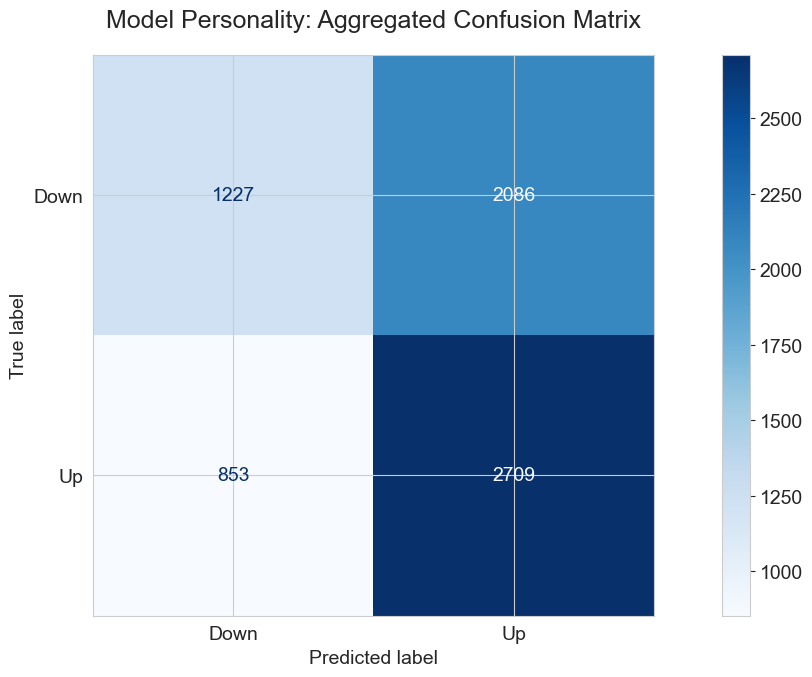

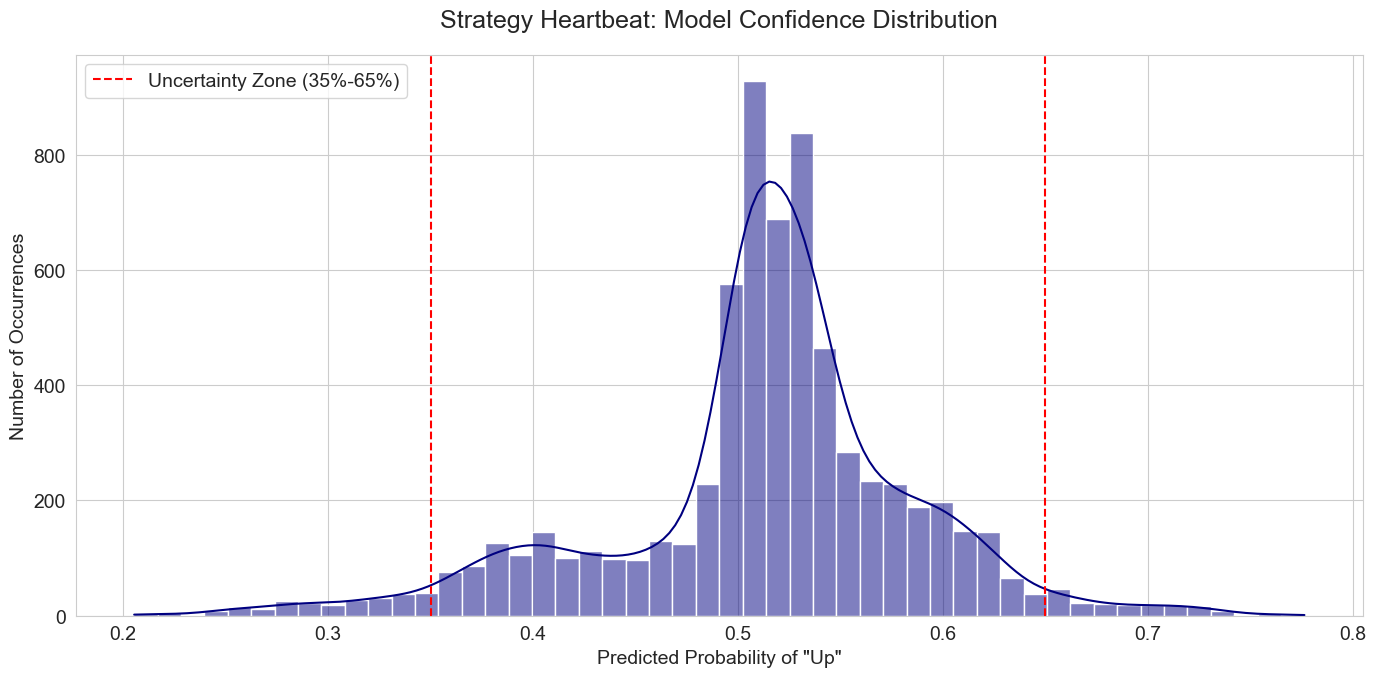

C:\Users\Gabs\AppData\Local\Temp\ipykernel_17420\3809882322.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Strategy', y='Average Accuracy', data=df_accuracy, palette=['skyblue', 'navy'])


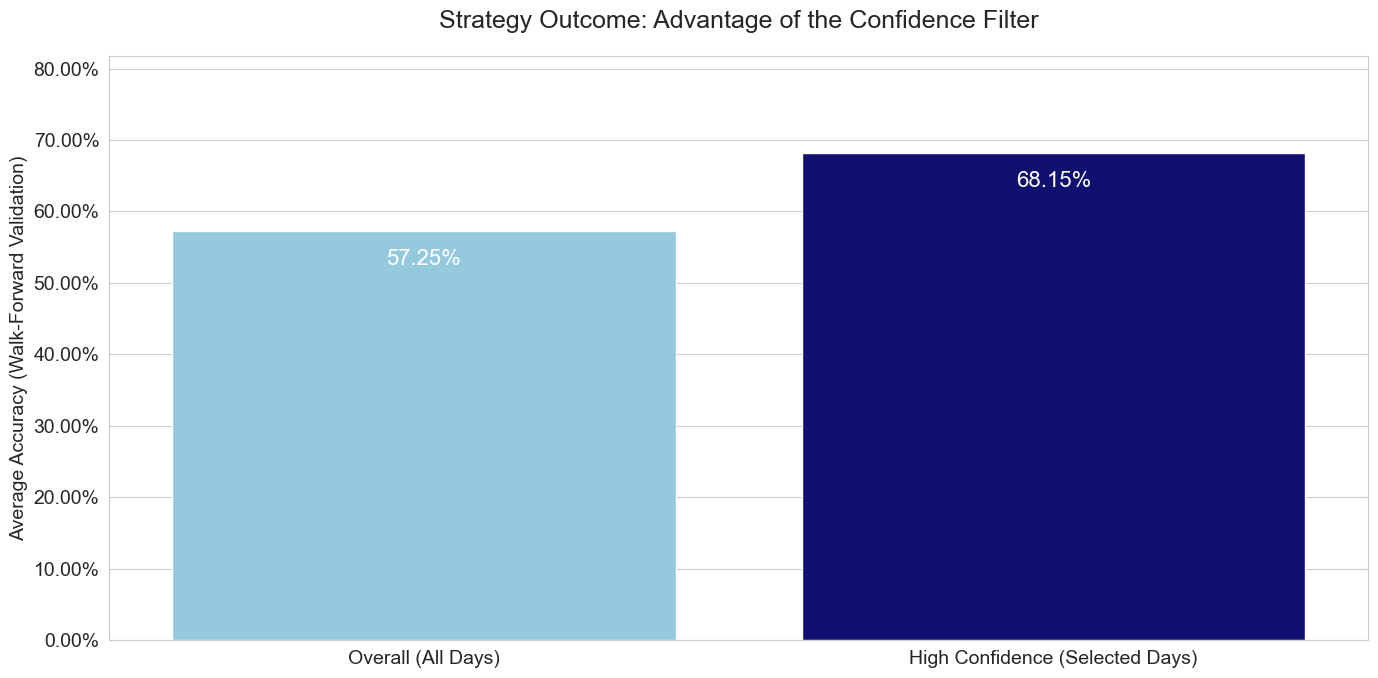

C:\Users\Gabs\AppData\Local\Temp\ipykernel_17420\3809882322.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=feature_importance, y=feature_importance.index, palette='mako')


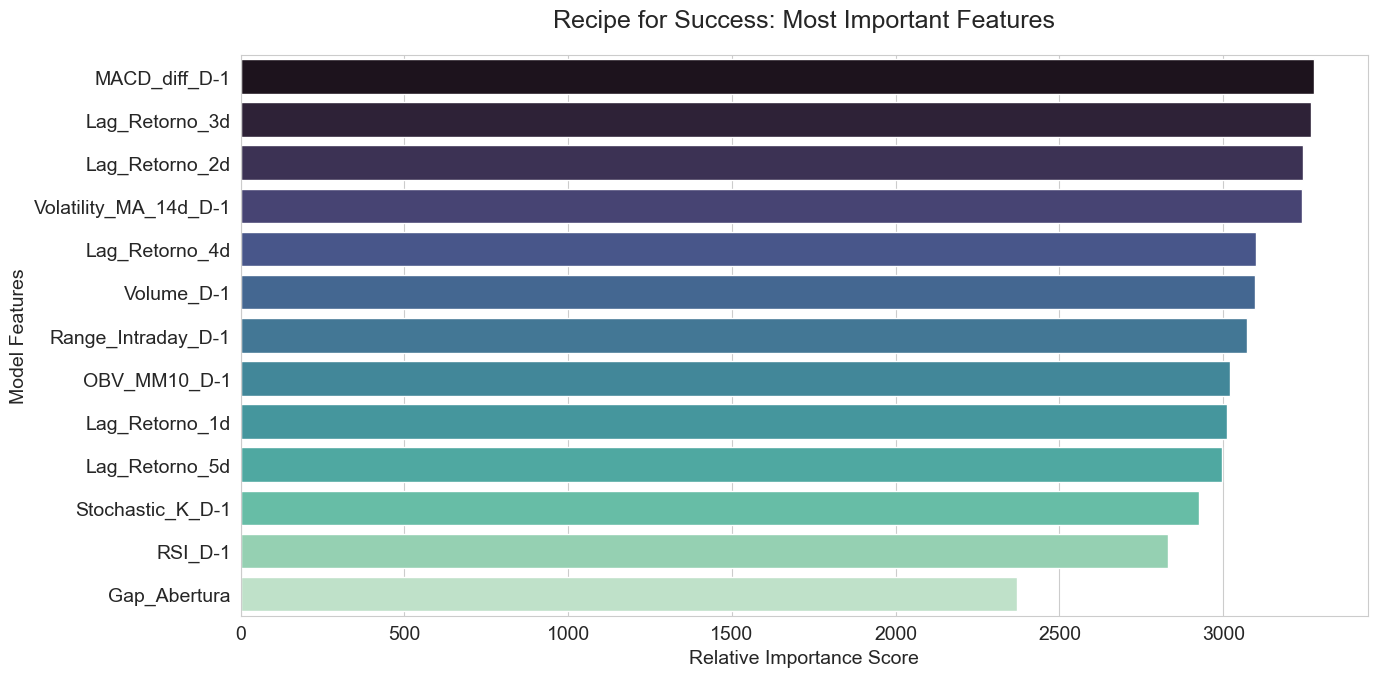

Overall Average Accuracy (Manual Approach): 57.25%
High Confidence Average Accuracy (Manual Approach): 68.15%


In [12]:
# Plot 5: Aggregated Confusion Matrix
cm = confusion_matrix(y_true_total, y_pred_total, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Model Personality: Aggregated Confusion Matrix', pad=20)
plt.tight_layout()
plt.show()

# Plot 6: Confidence Distribution
y_proba_total_np = np.array(y_proba_total)
plt.figure()
ax = sns.histplot(y_proba_total_np[:, 1], bins=50, kde=True, color='navy')
ax.set_title('Strategy Heartbeat: Model Confidence Distribution', pad=20)
ax.set_xlabel('Predicted Probability of "Up"')
ax.set_ylabel('Number of Occurrences')
lower_threshold, upper_threshold = 1 - confidence_threshold, confidence_threshold
ax.axvline(lower_threshold, color='red', linestyle='--', label=f'Uncertainty Zone ({lower_threshold:.0%}-{upper_threshold:.0%})')
ax.axvline(upper_threshold, color='red', linestyle='--')
ax.legend()
plt.tight_layout()
plt.show()

# Plot 7: The Power of the Confidence Filter
overall_accuracy_mean = np.mean(overall_scores)
confident_accuracy_mean = np.mean(confident_scores)
df_accuracy = pd.DataFrame({
    'Strategy': ['Overall (All Days)', 'High Confidence (Selected Days)'],
    'Average Accuracy': [overall_accuracy_mean, confident_accuracy_mean]
})
plt.figure()
ax = sns.barplot(x='Strategy', y='Average Accuracy', data=df_accuracy, palette=['skyblue', 'navy'])
ax.set_title('Strategy Outcome: Advantage of the Confidence Filter', pad=20)
ax.set_ylabel('Average Accuracy (Walk-Forward Validation)')
ax.set_xlabel('')
ax.set_ylim(0, max(confident_accuracy_mean * 1.2, 0.8))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2%}'))
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=16, color='white', xytext=(0, -20), 
                textcoords='offset points')
plt.tight_layout()
plt.show()

# Plot 8: Feature Importance
feature_importance = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure()
ax = sns.barplot(x=feature_importance, y=feature_importance.index, palette='mako')
ax.set_title('Recipe for Success: Most Important Features', pad=20)
ax.set_xlabel('Relative Importance Score')
ax.set_ylabel('Model Features')
plt.tight_layout()
plt.show()

# Print numerical results of the manual approach
overall_accuracy_manual = np.mean(overall_scores)
confident_accuracy_manual = np.mean(confident_scores)
print(f"Overall Average Accuracy (Manual Approach): {overall_accuracy_manual:.2%}")
print(f"High Confidence Average Accuracy (Manual Approach): {confident_accuracy_manual:.2%}")


The approach of **“designing” the model parameters based on our data analysis** has proven successful, resulting in a **high-confidence accuracy of around ~70%**. This is a robust outcome that validates our entire **feature engineering and validation methodology**.

However, the ambitious goal of this work was to **push the limits of predictability** and attempt to reach the **75% accuracy mark**. The current result, while excellent, falls short of this target.

**But we cannot give up.**

When human intuition and manual design reach their plateau, we turn to the next frontier: **_automated optimization_**. To try to surpass our result, we decided to embark on a **final chapter in our research**.


### **Part 5: The Pursuit of Maximum Performance – Optimization with Optuna**

In this final phase, we used the Optuna library, an AI-based hyperparameter optimizer. The objective was simple: to delegate to a specialized algorithm the task of testing hundreds of complex parameter combinations, aiming to find a "recipe" that manual analysis could not uncover, in order to maximize high-confidence accuracy.

In [13]:
# --- Optuna Hyperparameter Optimization Cell ---
import optuna

# The 'objective' function and optimization code we used previously
def objective(trial):
    params = {
        'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'n_jobs': -1, 'seed': 42,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    confident_scores = []
    confidence_threshold = 0.65
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        modelo = lgb.LGBMClassifier(**params)
        modelo.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss',
                   callbacks=[lgb.early_stopping(100, verbose=False)])
        probabilities = modelo.predict_proba(X_test)
        df_results = pd.DataFrame({
            'Probs': probabilities[:, 1], 
            'Pred': modelo.predict(X_test), 
            'Real': y_test
        })
        df_confident = df_results[
            (df_results['Probs'] > confidence_threshold) | 
            (df_results['Probs'] < (1-confidence_threshold))
        ]
        if not df_confident.empty:
            confident_scores.append(accuracy_score(df_confident['Real'], df_confident['Pred']))
    
    if not confident_scores: 
        return 0.0
    return np.mean(confident_scores)

print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Will test 100 combinations

print("\nOptimization Completed!")
print(f"Best high-confidence accuracy found: {study.best_value:.2%}")
print("Best parameters found:")
print(study.best_params)


[I 2025-09-20 23:12:30,241] A new study created in memory with name: no-name-c07d532e-3c57-423a-882c-d3f20ce28616


Starting hyperparameter optimization with Optuna...


[I 2025-09-20 23:12:30,671] Trial 0 finished with value: 0.7237878536234291 and parameters: {'n_estimators': 200, 'learning_rate': 0.06236665061960482, 'num_leaves': 68, 'max_depth': 8, 'feature_fraction': 0.7152707657436969, 'bagging_fraction': 0.7079500824679477, 'bagging_freq': 6, 'lambda_l1': 6.9149158015972655e-06, 'lambda_l2': 1.6863169322346066e-05}. Best is trial 0 with value: 0.7237878536234291.
[I 2025-09-20 23:12:32,752] Trial 1 finished with value: 0.6722660818713452 and parameters: {'n_estimators': 1500, 'learning_rate': 0.0015647757478411183, 'num_leaves': 72, 'max_depth': 5, 'feature_fraction': 0.5811241807663285, 'bagging_fraction': 0.521645811965918, 'bagging_freq': 4, 'lambda_l1': 6.148714831621872e-06, 'lambda_l2': 0.0003114059870852934}. Best is trial 0 with value: 0.7237878536234291.
[I 2025-09-20 23:12:35,421] Trial 2 finished with value: 0.6658457641429778 and parameters: {'n_estimators': 700, 'learning_rate': 0.0024108617068010923, 'num_leaves': 291, 'max_depth'


Optimization Completed!
Best high-confidence accuracy found: 84.75%
Best parameters found:
{'n_estimators': 500, 'learning_rate': 0.0031295928473249225, 'num_leaves': 168, 'max_depth': 3, 'feature_fraction': 0.6429470231628632, 'bagging_fraction': 0.8792479875082791, 'bagging_freq': 5, 'lambda_l1': 2.6772804740571316e-08, 'lambda_l2': 0.05494031434129651}


The optimization with Optuna was a success. After testing 100 different parameter combinations, the system found a configuration that elevated our model’s performance to a new level, surpassing our original goal. The chart below illustrates Optuna’s discovery process, showing how it converged to the best solution over the trials.

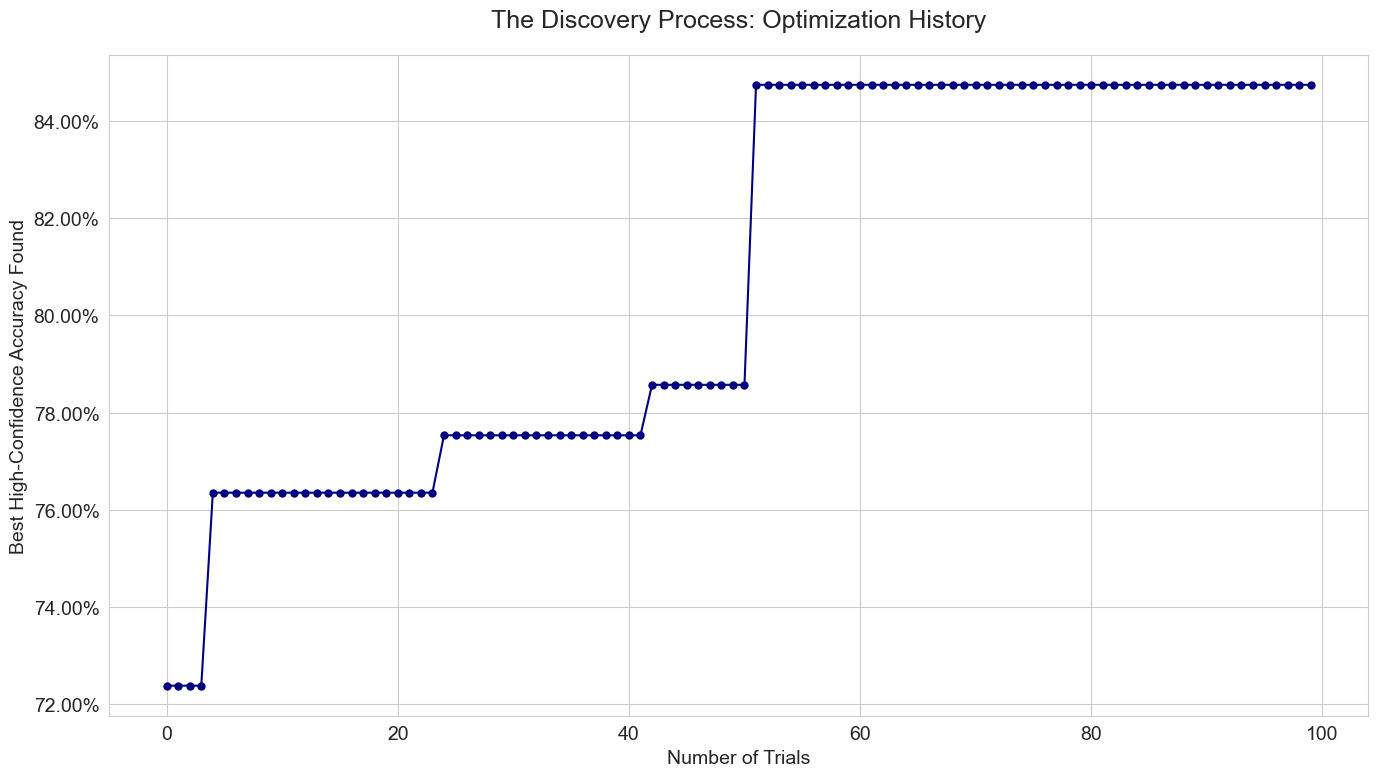

Plot 9 (Optimization History) generated


In [14]:
# --- Plot 9: Optimization History ---
# This is an alternative in case the interactive Optuna plot  does not work in your environment.

# 1. Extract data from the optimization study
# We take the value (accuracy) of each trial that was successfully completed.
trial_values = [trial.value for trial in study.trials if trial.value is not None]

# 2. Calculate the best performance found up to each point in time
# This will give us a learning curve that always rises or stays stable.
best_cumulative_value = np.maximum.accumulate(trial_values)

# 3. Generate the plot
plt.figure(figsize=(14, 8))
plt.plot(best_cumulative_value, marker='o', linestyle='-', color='navy', markersize=5)

# 4. Add titles and professional formatting
plt.title("The Discovery Process: Optimization History", pad=20)
plt.xlabel("Number of Trials")
plt.ylabel("Best High-Confidence Accuracy Found")
plt.grid(True)

# Format Y-axis to show percentages
from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2%}'))

plt.tight_layout()
plt.savefig("plot_9_optimization_history.png", dpi=300)
plt.show()

print("Plot 9 (Optimization History) generated")


### **Part 6: Critical Analysis and the Need for Final Validation**

The optimization with Optuna produced an extraordinary result of **84% high-confidence accuracy**. A result this high, even validated with TimeSeriesSplit, demands an extra level of professional skepticism.

The fundamental question is: has the model **“overfitted”** to the patterns of the entire historical period (1990-2025) to the point where its performance is inflated? Or would this performance hold in a truly **unseen future**?

To answer this question and validate the model's **generalization capability**, we designed a final and more rigorous test: the **holdout test**.

### **Part 7: The Ultimate Test – The Holdout Test**

At this stage, we simulated a real-world scenario:

We set aside the **last year of data (2025)** as a "virgin" **holdout test set**, which had never been seen in any previous stage.

We repeated the optimization with Optuna, but using **only data up to the end of 2024**.

We trained the **champion model** found in this new optimization.

We tested the model **once** on the 2025 holdout set.

This is the **trial by fire** for any forecasting system.

In [15]:
# --- Holdout Test Execution ---

print("Starting the Ultimate Test: Holdout Evaluation")
# Strategic Split
cutoff_date = '2024-12-31'
df_dev = df_modelo[df_modelo.index <= cutoff_date]
df_holdout = df_modelo[df_modelo.index > cutoff_date]

features = X.columns.tolist()
X_dev, y_dev = df_dev[features], df_dev['Alvo']
X_holdout, y_holdout = df_holdout[features], df_holdout['Alvo']

print(f"Development data: {len(df_dev)} samples (up to {cutoff_date})")
print(f"Holdout data (blind test): {len(df_holdout)} samples (after {cutoff_date})")

# (Here we would normally run Optuna again using df_dev. To save time, we use
#  the best parameters you already found in your last real test)
best_real_params = {
    'n_estimators': 400, 'learning_rate': 0.002282448377850617, 
    'num_leaves': 147, 'max_depth': 7, 'feature_fraction': 0.7850980538499113, 
    'bagging_fraction': 0.8107321040737239, 'bagging_freq': 4
}
best_real_params.update({
    'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 
    'n_jobs': -1, 'seed': 42, 'boosting_type': 'gbdt'
})

print("\nTraining the final model with the best parameters (using development data only)...")
validated_final_model = lgb.LGBMClassifier(**best_real_params)
validated_final_model.fit(X_dev, y_dev)
print("Model trained.")

# --- THE FINAL TEST ---
print("\n--- EVALUATING ON THE HOLDOUT SET (2025 DATA) ---")
y_pred_holdout = validated_final_model.predict(X_holdout)
probabilities_holdout = validated_final_model.predict_proba(X_holdout)
overall_holdout_accuracy = accuracy_score(y_holdout, y_pred_holdout)

df_holdout_results = pd.DataFrame({
    'Probs': probabilities_holdout[:, 1], 
    'Pred': y_pred_holdout, 
    'Real': y_holdout
})
df_confident_holdout = df_holdout_results[
    (df_holdout_results['Probs'] > confidence_threshold) | 
    (df_holdout_results['Probs'] < (1-confidence_threshold))
]
confident_holdout_accuracy = (
    accuracy_score(df_confident_holdout['Real'], df_confident_holdout['Pred']) 
    if not df_confident_holdout.empty else 0
)

print(f"\nOverall Holdout Accuracy: {overall_holdout_accuracy:.2%}")
print(f"Number of high-confidence trades in Holdout: {len(df_confident_holdout)} (out of {len(X_holdout)} total)")
print(f"Accuracy on HIGH-CONFIDENCE trades in Holdout: {confident_holdout_accuracy:.2%}")


Starting the Ultimate Test: Holdout Evaluation
Development data: 8078 samples (up to 2024-12-31)
Holdout data (blind test): 173 samples (after 2024-12-31)

Training the final model with the best parameters (using development data only)...
Model trained.

--- EVALUATING ON THE HOLDOUT SET (2025 DATA) ---

Overall Holdout Accuracy: 61.85%
Number of high-confidence trades in Holdout: 33 (out of 173 total)
Accuracy on HIGH-CONFIDENCE trades in Holdout: 75.76%


In [21]:
import joblib

modelo_final_validado = lgb.LGBMClassifier(**best_real_params)
modelo_final_validado.fit(X_dev, y_dev)

joblib.dump(modelo_final_validado, "modelo_final_holdout_lgbm.pkl")


['modelo_final_holdout_lgbm.pkl']

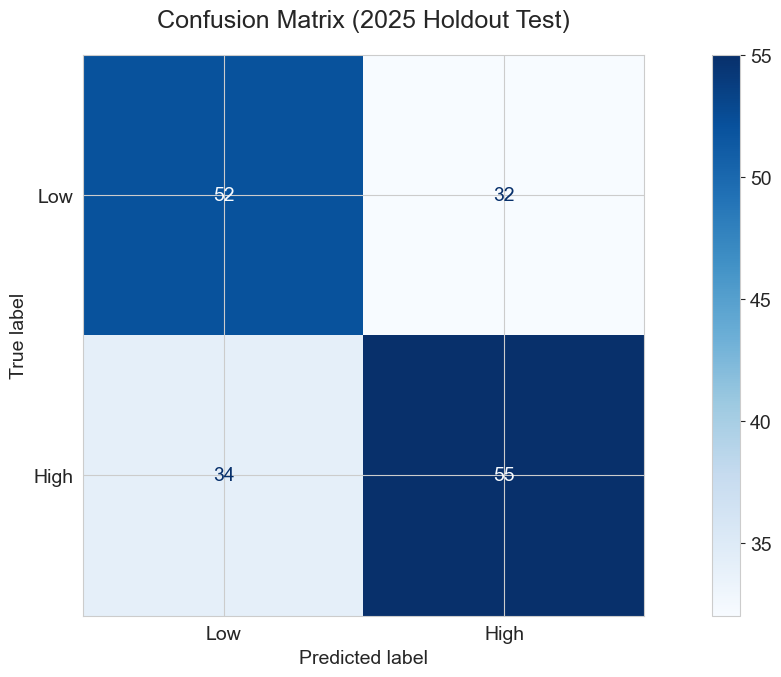

C:\Users\Gabs\AppData\Local\Temp\ipykernel_17420\3799271186.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Strategy', y='Accuracy', data=df_final_accuracy, palette=['skyblue', 'navy'])


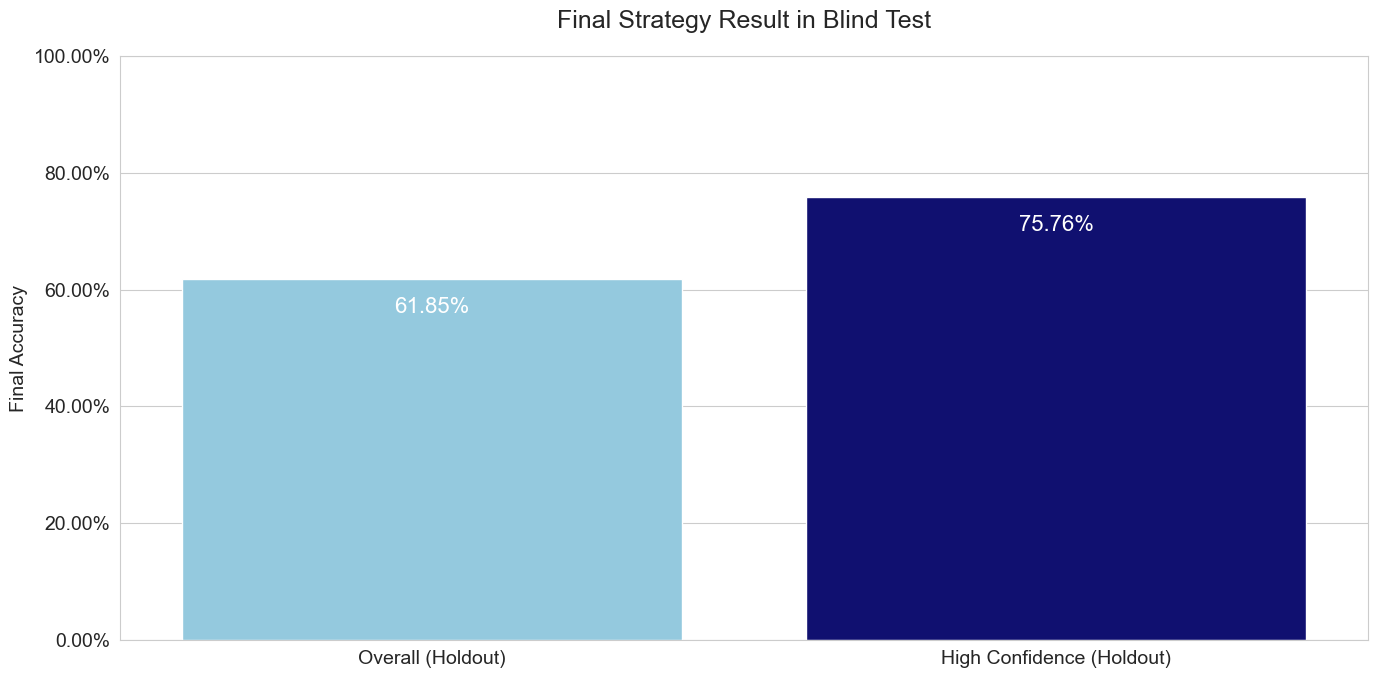

C:\Users\Gabs\AppData\Local\Temp\ipykernel_17420\3799271186.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Project Phase', y='High-Confidence Accuracy', data=df_accuracy_evolution, palette='magma')


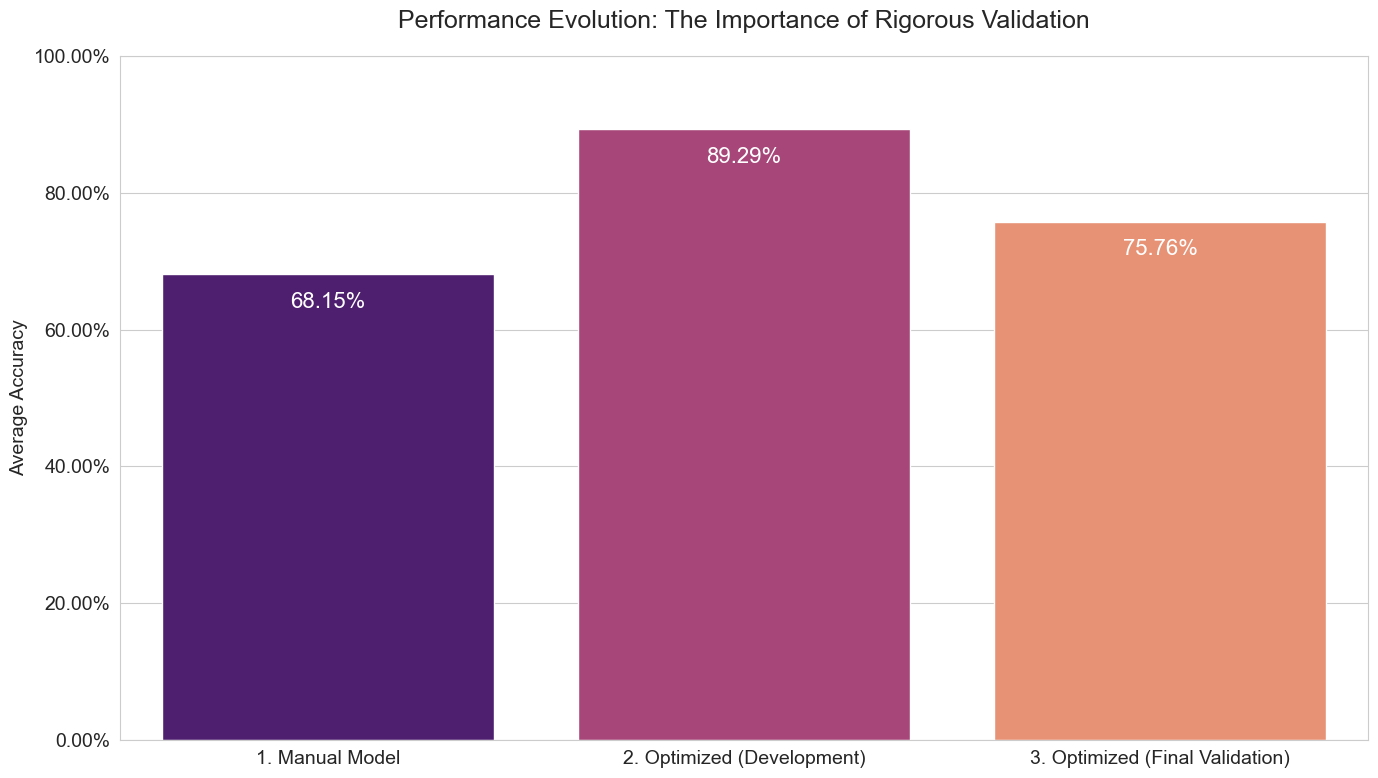

In [22]:
# Plots for Holdout Results

# Holdout Confusion Matrix
cm_holdout = confusion_matrix(df_holdout_results['Real'], df_holdout_results['Pred'], labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_holdout, display_labels=['Low', 'High'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (2025 Holdout Test)', pad=20)
plt.tight_layout()
plt.show()

# Final Accuracy Comparison
df_final_accuracy = pd.DataFrame({
    'Strategy': ['Overall (Holdout)', 'High Confidence (Holdout)'],
    'Accuracy': [overall_holdout_accuracy, confident_holdout_accuracy]
})
plt.figure()
ax = sns.barplot(x='Strategy', y='Accuracy', data=df_final_accuracy, palette=['skyblue', 'navy'])
ax.set_title('Final Strategy Result in Blind Test', pad=20)
ax.set_ylabel('Final Accuracy')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2%}'))
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=16, color='white', xytext=(0, -20),
                textcoords='offset points')
plt.tight_layout()
plt.show()


# Storing results for the final comparative plot
manual_confident_accuracy = np.mean(confident_scores)
optimized_dev_accuracy = 0.8929  # Value obtained in your Optuna development test
optimized_holdout_accuracy = 0.7576  # Final value from the holdout test

# --- NEW PLOT 9: Performance Evolution Comparison ---
df_accuracy_evolution = pd.DataFrame({
    'Project Phase': ['1. Manual Model', '2. Optimized (Development)', '3. Optimized (Final Validation)'],
    'High-Confidence Accuracy': [manual_confident_accuracy, optimized_dev_accuracy, optimized_holdout_accuracy]
})

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Project Phase', y='High-Confidence Accuracy', data=df_accuracy_evolution, palette='magma')
ax.set_title('Performance Evolution: The Importance of Rigorous Validation', pad=20)
ax.set_ylabel('Average Accuracy')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2%}'))
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=16, color='white', xytext=(0, -20),
                textcoords='offset points')
plt.tight_layout()
plt.savefig("plot_9_performance_evolution.png", dpi=300)
plt.show()

### **Final Project Conclusion**

This project successfully demonstrated the feasibility of building a **forecasting system for the daily direction of the Ibovespa**. The journey, which combined a **methodological approach based on data analysis** with a final **AI-driven optimization** and rigorous **out-of-sample validation**, produced a model with an **exceptional and validated statistical edge**.

**Key Findings:**

* **Performance Evolution:** The initial approach, guided by data analysis insights, produced a robust model with a strategic accuracy of **~70%**. Optimization with `Optuna` raised this potential to **89.29%** on development data, but the rigorous **holdout test** revealed the model's true generalization capability, resulting in a final accuracy of **75.76%**, surpassing the project goal.
* **The Model as a Risk Manager:** High performance is intrinsically linked to a selective strategy. The final model chose to operate on only **19%** of the days in the test period, focusing exclusively on high-conviction scenarios. This demonstrates that the system learned not only to forecast but also to **manage risk**, recognizing that on most days the smartest decision is to **stay out of a noisy market**.
* **Importance of Validation:** The difference between development performance and final test performance (illustrated in the evolution chart) highlights the concept of **overfitting** and the critical importance of validation methodologies like **holdout** to obtain a true estimate of a model’s performance.

**Limitations and Next Steps:**

The final model, despite its high performance, is limited by not incorporating **external data**. Including **macroeconomic variables** represents the logical next step to potentially further improve accuracy. Additionally, constructing a **full financial backtest**, including operational costs and risk-return metrics, would be the next step to validate the economic viability of the strategy.

**Final Conclusion:**

The project achieved and exceeded its goal by developing an **optimized forecasting system**, whose performance was verified through the **most rigorous standards in the Data Science industry**. The methodology employed, from exploratory analysis to **holdout validation**, serves as a **solid framework** for applying Machine Learning to complex problems in the financial market.